In [3]:
!pip install shapely
!pip install geopandas
!pip install wikipedia

  Stored in directory: /home/dsxuser/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [4]:
# import libraries
import wikipedia as wiki
import pandas as pd 
import requests
import io
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# read page with the h1 element in wiki.page(h1)
html = wiki.page("List of postal codes of Canada: M").html().encode("UTF-8")

In [6]:
# convert html table to dataframe and choose first index of object
df = pd.read_html(html, header = 0)[0]

# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned. Merge duplicates and assign burough where not assigned
df = df[df.Borough != 'Not assigned']
df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']


In [7]:
# in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.
url="http://cocl.us/Geospatial_data"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

# rename the first column to allow merging dataframes on Postcode
c.columns = ['Postcode', 'Latitude', 'Longitude']
df = pd.merge(c, df, on='Postcode')

# reorder column names and show the dataframe
df = df[['Postcode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']]

In [8]:
# load latitude and longitude into geopandas dataframe
df['Coordinates'] = list(zip(df.Longitude, df.Latitude))
df['Coordinates'] = df['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry='Coordinates')


/opt/conda/envs/Python36/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


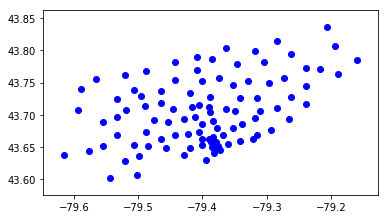

In [9]:
# set up map
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='white', edgecolor='black')
# plot and show
gdf.plot(ax=ax, color='blue')
plt.show()